In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from src.distribution_analysis.process_tree import get_observed_nodes

import seaborn as sns
from src.distribution_analysis.process_tree import get_observed_nodes, get_clade_split_df
from src.datasets.load_trees import load_trees, TreeDataset
from src.utils.tree_utils import get_taxa_names

In [38]:
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [39]:
DATA_SET = TreeDataset.DS_4
DATA_SET_NAME = DATA_SET.value

### Load trees

In [40]:
trees = load_trees(DATA_SET, max_trees=50_000)

1it [01:57, 117.97s/it]


In [41]:
taxa_names = get_taxa_names(trees[0])
observed_nodes, observed_clade_splits = get_observed_nodes(trees, taxa_names)
df_clade_splits = get_clade_split_df(observed_clade_splits)

50000it [00:06, 7843.50it/s]
100%|██████████| 2000000/2000000 [00:01<00:00, 1074435.24it/s]


In [63]:
len(observed_clade_splits)

2000000

### Analyze clade split heights

In [42]:
df_clade_splits["height"].describe()

count    2.000000e+06
mean     2.130114e-01
std      6.359708e-02
min      0.000000e+00
25%      1.920537e-01
50%      2.276862e-01
75%      2.540767e-01
max      3.759094e-01
Name: height, dtype: float64

In [43]:
%%script true

grid = sns.FacetGrid(df_clade_splits, col="clade_split", col_wrap=8, height=2)
grid.map(sns.histplot, "height", kde=True, stat="density")

### Analyze observed branch lengths

In [44]:
df_clade_splits["min_branch"].describe()

count    2.000000e+06
mean     2.481563e-02
std      2.331224e-02
min      1.215920e-07
25%      9.915210e-03
50%      1.768277e-02
75%      3.174048e-02
max      2.848041e-01
Name: min_branch, dtype: float64

<Axes: xlabel='left_branch', ylabel='right_branch'>

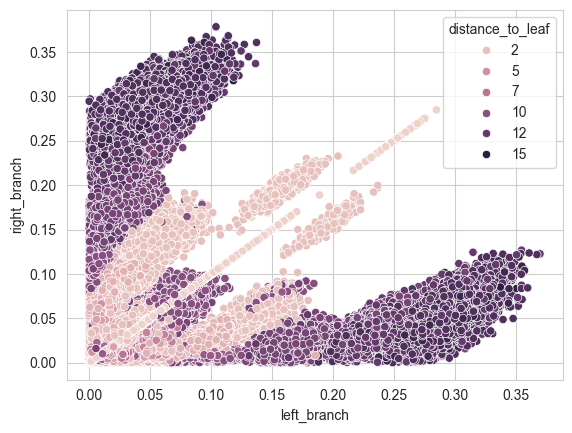

In [45]:
sns.scatterplot(data=df_clade_splits, x="left_branch", y="right_branch", hue="distance_to_leaf")

### Analyze branch lengths per clade split

Text(0.5, 1.0, 'Branch length correlation by distance to leaf (DS4)')

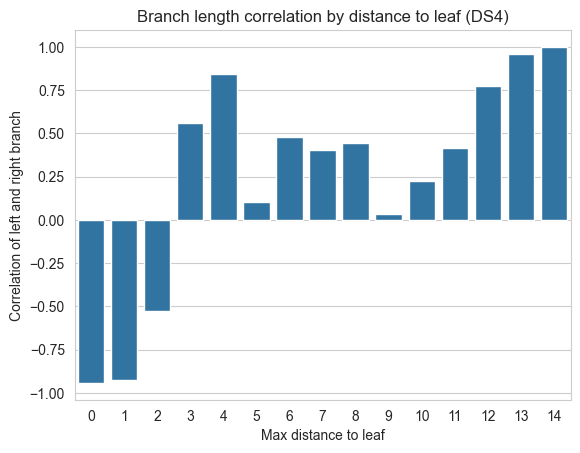

In [51]:
avg_correlation_per_level = df_clade_splits.groupby("distance_to_root").apply(
    lambda y: y["left_branch"].corr(y["right_branch"])
)
sns.barplot(data=avg_correlation_per_level)

plt.ylabel("Correlation of left and right branch")
plt.xlabel("Max distance to leaf")

plt.title(f"Branch length correlation by distance to leaf ({DATA_SET_NAME})")

In [56]:
import pandas as pd
from tqdm import tqdm

from src.distribution_analysis.clade import ObservedCladeSplit


df_dict = {
    "min_branch_0": [],
    "min_branch_1": [],
    "min_branch_2": [],
    "min_branch_l": [],
    "min_branch_r": [],
}

for clade_split in tqdm(observed_clade_splits):
    min_branch_0 = clade_split.min_branch_length

    min_branch_1 = None
    min_branch_2 = None
    min_branch_l = None
    min_branch_r = None

    if isinstance(clade_split.min_branch_clade, ObservedCladeSplit):
        min_branch_1 = clade_split.min_branch_clade.min_branch_length

        if isinstance(clade_split.min_branch_clade.min_branch_clade, ObservedCladeSplit):
            min_branch_2 = clade_split.min_branch_clade.min_branch_clade.min_branch_length

    if isinstance(clade_split.left_clade, ObservedCladeSplit):
        min_branch_l = clade_split.left_clade.min_branch_length
    
    if isinstance(clade_split.right_clade, ObservedCladeSplit):
        min_branch_r = clade_split.right_clade.min_branch_length

    df_dict["min_branch_0"].append(min_branch_0)
    df_dict["min_branch_1"].append(min_branch_1)
    df_dict["min_branch_2"].append(min_branch_2)
    df_dict["min_branch_l"].append(min_branch_l)
    df_dict["min_branch_r"].append(min_branch_r)

df_extended_branches = pd.DataFrame(df_dict)

100%|██████████| 2000000/2000000 [00:03<00:00, 630822.48it/s]


<Axes: >

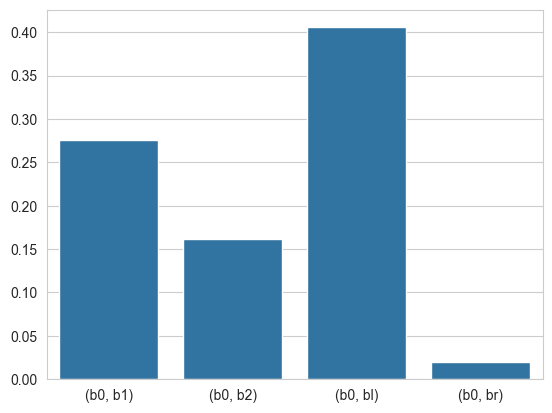

In [57]:
sns.barplot(
    x=["(b0, b1)", "(b0, b2)", "(b0, bl)", "(b0, br)"],
    y=[
        df_extended_branches["min_branch_0"].corr(df_extended_branches["min_branch_1"]),
        df_extended_branches["min_branch_0"].corr(df_extended_branches["min_branch_2"]),
        df_extended_branches["min_branch_0"].corr(df_extended_branches["min_branch_l"]),
        df_extended_branches["min_branch_0"].corr(df_extended_branches["min_branch_r"]),
    ]
)

### Min branch length distributions

In [54]:
df_most_common_branches_splits = df_clade_splits[df_clade_splits.clade_split.isin(df_clade_splits.clade_split.value_counts().nlargest(16).index)]

Text(0.5, 0.98, 'Distribution of d_min per clade split (DS4)')

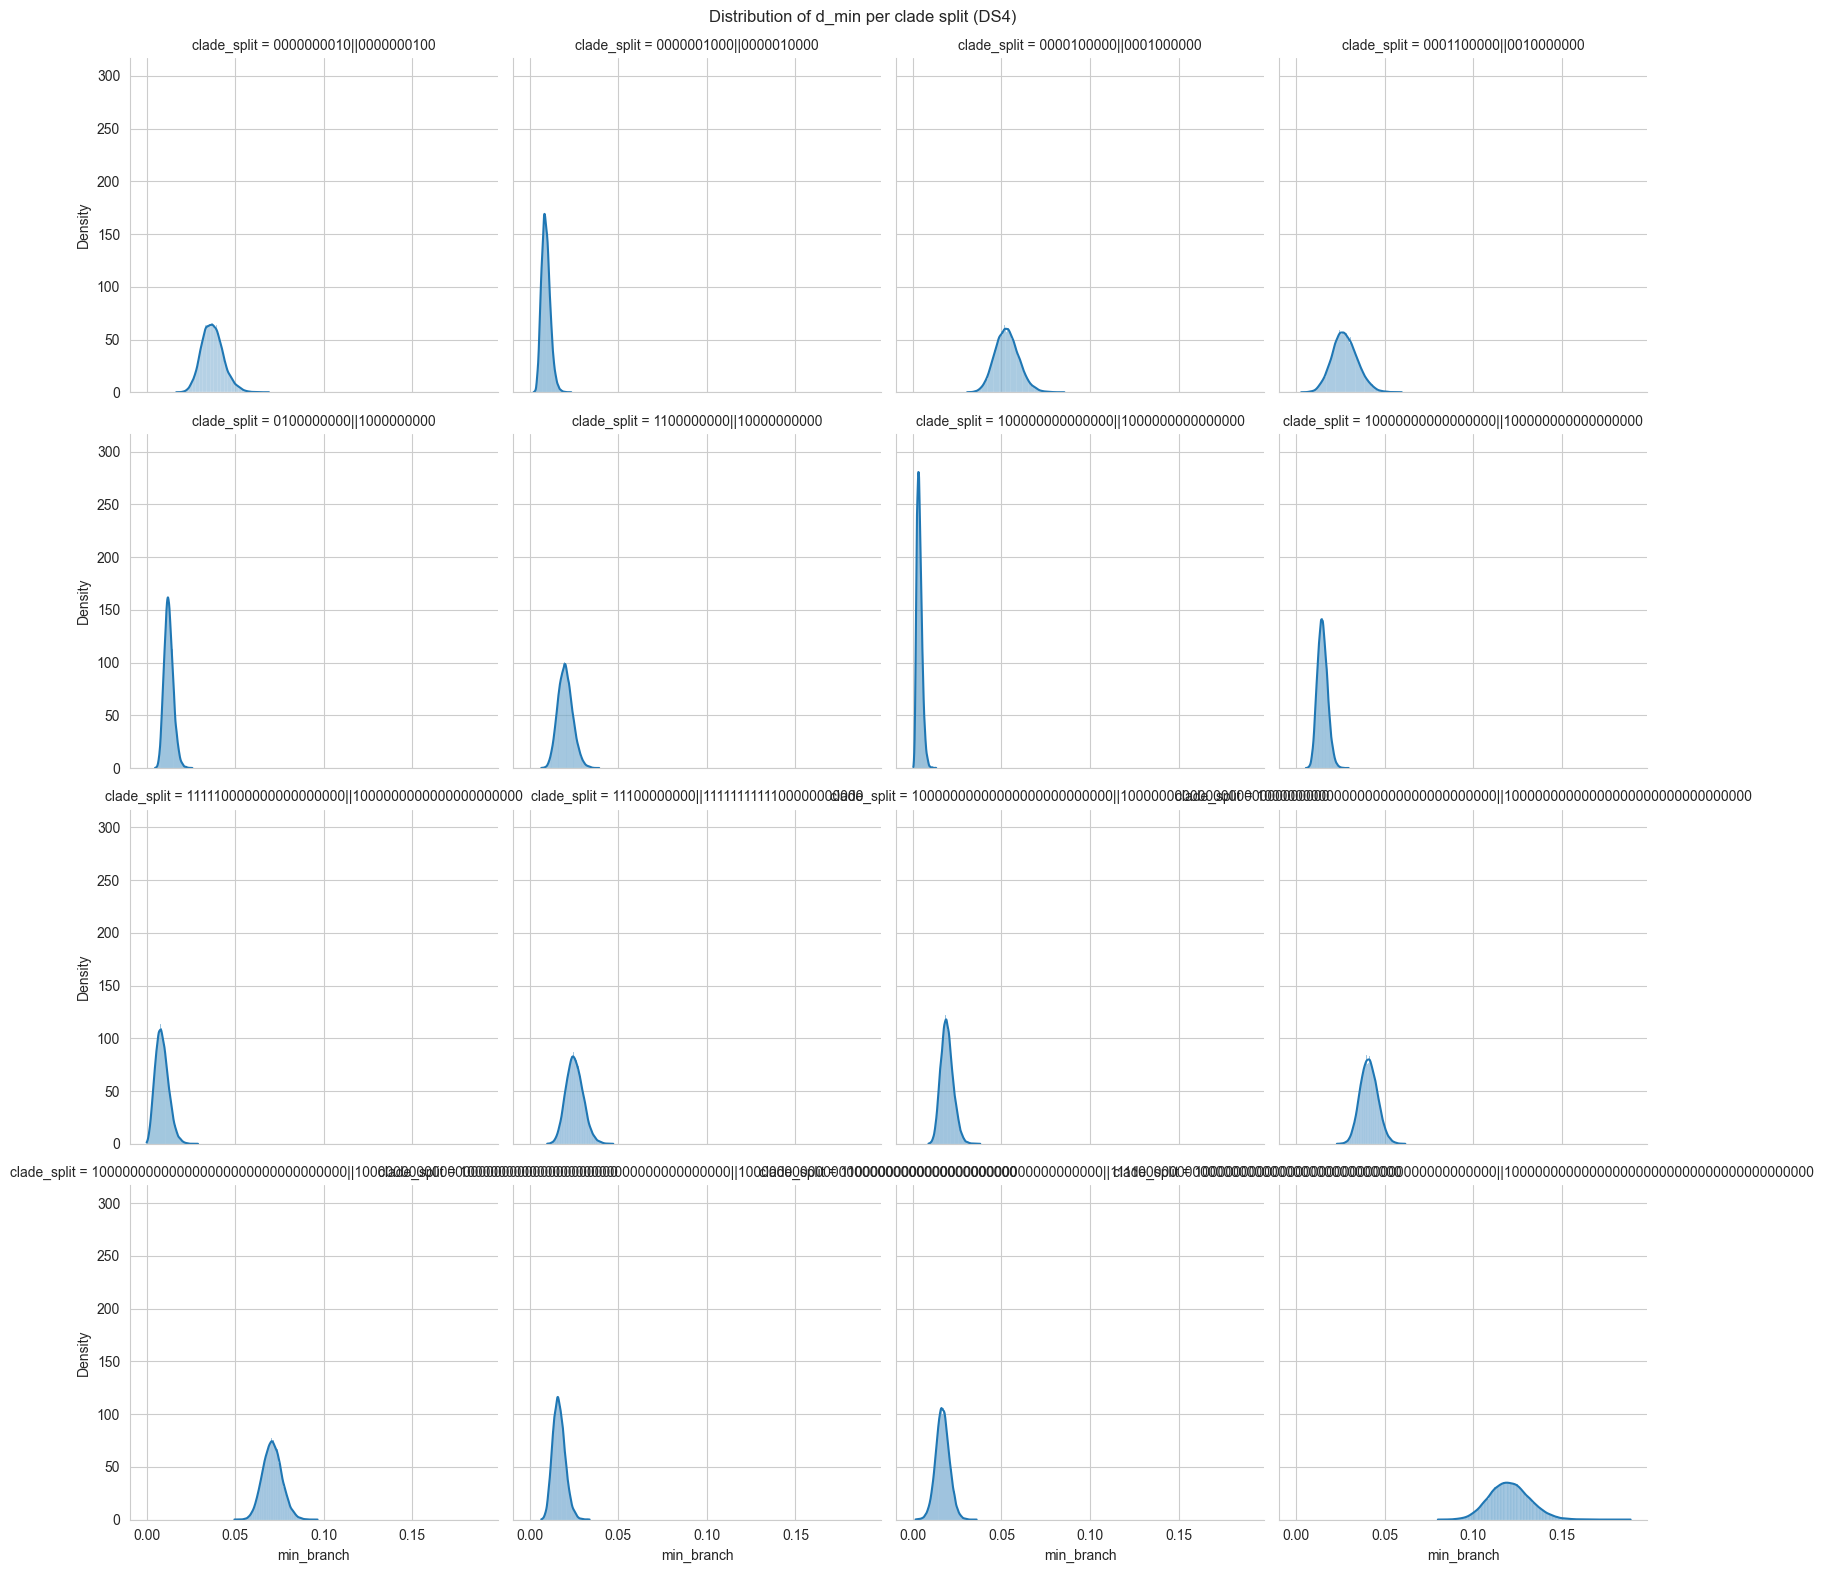

In [55]:
grid = sns.FacetGrid(df_most_common_branches_splits, col="clade_split", col_wrap=4, height=4)
grid.map(sns.histplot, "min_branch", kde=True, stat="density")

grid.figure.subplots_adjust(top=0.95)
grid.figure.suptitle(f"Distribution of d_min per clade split ({DATA_SET_NAME})")